# Pipelines en scikit-learn
El objetivo de esta sección es mostrar cómo se pueden desarrollar flujos de preprocesamiento en `sklearn`. Vamos a explorar las diferentes operaciones que se le pueden hacer a los diferentes tipos de variables y cómo agrupar todas las operaciones en un solo elemento de `sklearn` que tenga los métodos `.fit()` y `.transform()`

In [1]:
import numpy as np
import pandas as pd

from typing import List
from sklearn import set_config
set_config(display='diagram')

In [2]:
data = pd.read_csv(
    "https://factored-workshops.s3.amazonaws.com/taxi-trip-duration.csv"
)
# Limitar rango de datos
tiempo_minimo = 60 # 1 minuto
tiempo_maximo = 36000 # 10 horas
data = data[
    (data["trip_duration"] > tiempo_minimo) &
    (data["trip_duration"] < tiempo_maximo)
]
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_borough,dropoff_borough
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Manhattan,Manhattan
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Manhattan,Brooklyn
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Manhattan,Brooklyn
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Brooklyn,Brooklyn
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Manhattan,Manhattan


Es importante siempre separar la variable dependiente en este caso `trip_duration` del dataframe que vamos a usar para crear las variables independientes.

In [3]:
data['store_and_fwd_flag'].value_counts()

N    1439947
Y       7908
Name: store_and_fwd_flag, dtype: int64

In [4]:
y = data["trip_duration"] # variable a predecir
input_df = data.drop(
    ["id", "trip_duration", "dropoff_datetime", "store_and_fwd_flag"],
    axis="columns"
)

## División de los datos
Un paso que siempre se debe hacer es dividir los datos disponibles entrenamiento, validación y test. En este caso vamos a dividir los datos disponibles en sets de entrenamiento y validación con la función `train_test_split`

In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df, y_train, y_val = train_test_split(input_df, y, random_state=0)

## Transformers
`scikit-learn` incluye una gran lista [lista](https://scikit-learn.org/stable/data_transforms.html) de transformers que nos permiten limpiar y transformar datos dependiendo de nuestro objetivo. Sin importar el tipo de transformacion que apliquen, todos los transformers siguen la convención de tener por lo menos dos métodos:

* `.fit()` calcula los parámetros necesarios para realizar la transformación a partir de unos datos de entrada. Este método se ejecuta únicamente en los datos de entrenamiento para asegurarnos que los parámetros no contienen información de los datos de validación.

* `.transform()` aplica la transformación a los datos.

Veamos un ejemplo usando `StandardScaler`, un transformer que nos permite remover la media y escalar los datos para que tengan varianza de 1. Vamos a usarlo para normalizar los coordenadas de inicio del viaje

In [6]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler()
transformer.fit(
    train_df[["pickup_longitude", "pickup_latitude"]]
)
normed_array = transformer.transform(
    val_df[["pickup_longitude", "pickup_latitude"]]
)
print(normed_array)

[[-0.30923835 -0.27478234]
 [-0.13589444  0.75675283]
 [ 0.24599071  0.58169127]
 ...
 [-0.19727957 -0.13002453]
 [-0.03955223 -0.08161096]
 [-0.11150857 -0.79791458]]


### Custom Transformers

A pesar de que `scikit-learn` ofrece varias operaciones para transformar datos, frecuentemente necesitamos crear transformaciones que son específicas a nuestro proyecto. Para esto vamos a aprender cómo implementar custom transformers.

Todos los transformer custom deben heredar `BaseEstimator` y `TransformerMixin` para que tengan todas las funciones necesarias para conectarse a otros objetos de `sklearn`. Por convención de sklearn, los objetos usados para transformar datos siempre deben tener los métodos `.fit()` y `.transform()`. Ambos métodos reciben `X` y `y` para que se integren sin problemas a pipelines de sklearn. 

El método `.fit()` sirve para almacenar cantidades que vamos a usar durante la transformación de los datos y siempre debe retornar `self`. El método `.transform()` ejecuta la transformación y retorna los datos transformados. Ahora vamos a replicar el `StandardScaler` pero esta vez escribiéndolo como un transformer personalizado que no retorne un array sino un DataFrame.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class PrimerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean = X.mean()
        self.std = X.std()
        return self

    def transform(self, X, y=None):
        return (X - self.mean) / self.std

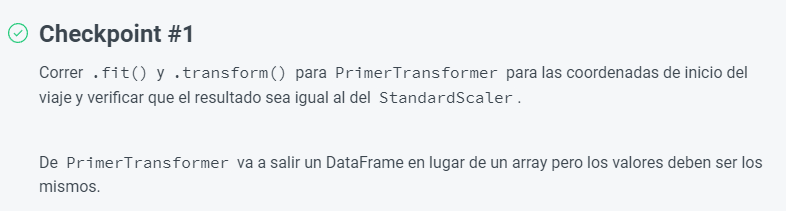

In [8]:
PrimerTransformer = PrimerTransformer()
PrimerTransformer.fit(
    train_df[["pickup_longitude", "pickup_latitude"]]
)
val_normed_df = PrimerTransformer.transform(
    val_df[["pickup_longitude", "pickup_latitude"]]
)
print(val_normed_df)

        pickup_longitude  pickup_latitude
5949           -0.309238        -0.274782
255492         -0.135894         0.756752
979171          0.245991         0.581691
121356          0.176797         0.385864
524382          0.194096         0.182913
...                  ...              ...
885062         -0.488949        -0.292409
755237         -0.565470        -1.408094
790367         -0.197279        -0.130024
106875         -0.039552        -0.081611
260937         -0.111509        -0.797914

[361964 rows x 2 columns]


In [9]:
normed_array == val_normed_df

,pickup_longitude,pickup_latitude
5949,False,False
255492,False,False
979171,False,False
121356,False,False
524382,False,False
...,...,...
885062,False,False
755237,False,False
790367,False,False
106875,False,False


En [este](https://scikit-learn.org/stable/developers/develop.html) link pueden encontrar más detalles de qué papel juegan los métodos `__init__`, `.fit()` y `.transform()`                   

### Transformer Fechas
Ahora que sabemos cómo construir objetos para transformar datos, vamos a crear un transformer para crear variables como el día de la semana y la hora del momento en el que empieza el servicio. Como vimos la semana pasada en nuestro EDA, esa información puede ser relevante para determinar la duración del viaje.

En nuestra transformación no debemos almacenar ningún dato para hacer las transformación entonces dejamos el método `.fit()` vacío. En `.transform()` extraemos los datos de fecha que nos interesan y retornamos un dataframe con las nuevas variables.

In [10]:
class TransformerFechas(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columna_fecha = pd.to_datetime(X["pickup_datetime"])
        fecha_df = pd.DataFrame()
        # TODO: Crear columnas con dia de la semana y hora de recogida.
        return fecha_df

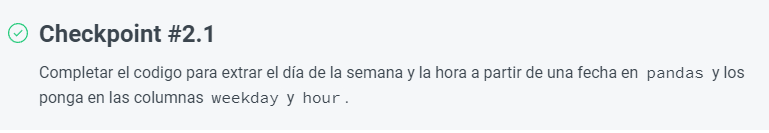

In [11]:
"""Como se va a crear nuevas variables no es necesario pasarle variables a nuestro fit
ya que el modelo no necesita aprender nada"""

class TransformerFechas(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columna_fecha = pd.to_datetime(X["pickup_datetime"])
        fecha_df = pd.DataFrame()
        fecha_df['weekday'] = columna_fecha.dt.weekday
        fecha_df['hour'] = columna_fecha.dt.hour
        # TODO: Crear columnas con dia de la semana y hora de recogida.
        return fecha_df

In [12]:
transformer_fechas = TransformerFechas()
fechas_df = transformer_fechas.fit_transform(train_df)
fechas_df.head()

,weekday,hour
518949,3,21
1128931,6,21
574396,1,18
54790,6,17
599130,0,16


### Transformer Distancia 
También queremos crear una feature que nos ayude a medir la distancia entre el punto de origen y el punto de destino usando la longitud y la latitud en los datos. Nuevamente no tenemos que almacenar cantidades en nuestro método `.fit()` y calculamos la distancia entre los dos puntos usando la [distancia de Haversine](https://es.wikipedia.org/wiki/F%C3%B3rmula_del_semiverseno). En el código ya está implementada la función para calcular la distancia y no es necesario fijarse en los detalles de la implementación. Como pueden ver, nuestros transformers pueden incluir funciones adicionales que nos ayuden a calcular cantidades útiles para realizar la transformación.

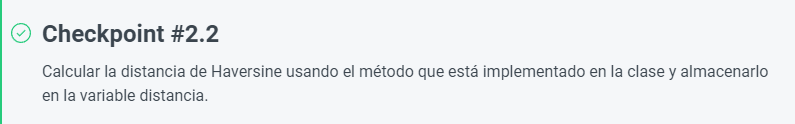

In [13]:
class TransformerDistancia(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_init = X[["pickup_latitude", "pickup_longitude"]].to_numpy()
        X_final = X[["dropoff_latitude", "dropoff_longitude"]].to_numpy()

        # Distancia de Haversine
        # TODO: Calcular la variable distancia usando la funcion
        # distancia de Haversine.
        distancia = self.distancia_haversine(X_init = X_init, X_final = X_final)
        distancia_df = pd.DataFrame()
        distancia_df["distancia"] = distancia
        return distancia_df
    
    def distancia_haversine(self, X_init, X_final):
        # Convertir de decimal a radianes
        X_init = np.radians(X_init)
        X_final = np.radians(X_final)

        # Formula Haversine
        dlat = X_final[:, 0] - X_init[:, 0] 
        dlon = X_final[:, 1] - X_init[:, 1]
        a = np.sin(dlat / 2) ** 2 + np.cos(X_init[:, 0]) * np.cos(X_final[:, 0]) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r

In [14]:
transformer_dist = TransformerDistancia()
distancias_df = transformer_dist.fit_transform(train_df)
distancias_df.head()

,distancia
0,2.404355
1,0.390267
2,5.629826
3,4.298386
4,7.488963


## Unión de transformers con Pipelines

### Pipeline Numérico
Ahora vamos a usar los objetos de `Pipeline` y `ColumnTransformer` para unir los transformers que ya hemos creado con otros disponibles en `sklearn` y lograr todas las transformaciones que queremos realizar a todos los datos.

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

`ColumnTransformer` nos permite elegir las columnas sobre las que queremos aplicar una transformación cuando nos llegan columnas adicionales. En este caso queremos que al `TransformerDistancia` llegue únicamente `pickup_longitude`, `pickup_latitude`, `dropoff_longitude` y `dropoff_latitude`.

Leyendo la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) sabemos que debemos pasar una tupla con el nombre del transformer, la clase que define el transformer y las columnas sobre las que queremos aplicar la transformación. `ColumnTransformer` también nos permite definir qué se debe hacer con las columnas que no estamos transformando; en este caso elegimos pasarlas sin transformarlas `remainder="passthrough"`.

In [16]:
coord_cols = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude"
]

transformer_coord = ColumnTransformer(
    [
        ("transformer_dist", TransformerDistancia(), coord_cols),
    ],
    remainder="passthrough"
)
display(transformer_coord)

ColumnTransformer(remainder='passthrough',
                  transformers=[('transformer_dist', TransformerDistancia(),
                                 ['pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude'])])

 Ahora que tenemos nuestro transformer que realiza transformación usando las coordenadas y deja pasar columnas adicionales, vamos a usarlo para unirlo con la otra variable númerica que tenemos en el dataset— `passenger_count`— y normalizarlas usando `StandardScaler`. Para esto vamos a usar el objeto Pipeline. 
 
`Pipeline` [(documentación Pipeline)](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) nos permite concatenar transformaciones de `sklearn`. En este caso vamos a concatenar el `ColumnTransformer` que creamos con `TransformerDistanci` con el `StandardScaler`. Como `passenger_count` no estaba entre columnas que selecciona `transformer_coord`, esa columna pasa directamente a ser normalizada por el `StandardScaler`

In [17]:
num_cols = ["passenger_count"] + coord_cols

num_pipeline = Pipeline(
    [
        ("transformer_coord", transformer_coord), # entra la variable distancia
        ("scaler", StandardScaler()) # entran las variables distancia y passenger_count
    ]
)

X_num = num_pipeline.fit_transform(train_df[num_cols], y_train)
print(X_num)

[[-0.25154928 -0.50616698]
 [-0.73141214  0.25385023]
 [ 0.51692963 -0.50616698]
 ...
 [-0.41058443 -0.50616698]
 [-0.3461049  -0.50616698]
 [ 1.33898968  0.25385023]]


Usando la función `display` podemos ver el diagrama del flujo que acabamos de crear. Por `TransformerDistancia` pasan las variables de longitud y latitud y por `passthrough` pasa cualquier columna que le pasemos al `ColumnTransformer` que no sean longitud o latitud—en este caso `passenger_count`. El último paso es aplicar un `StandardScalera` la variable de distancia que sale de `TransformerDistancia` y a las variables que vienen de `passthrough`

In [18]:
display(num_pipeline)

Pipeline(steps=[('transformer_coord',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer_dist',
                                                  TransformerDistancia(),
                                                  ['pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude'])])),
                ('scaler', StandardScaler())])

### Pipeline Categórico
Usaremos una lógica similar para las variables categóricas pero esta vez para concatenar el resultado de extraer variables temporales de la fecha de inicio del viaje con un `OneHotEncoder` para las variables categóricas de los datos.

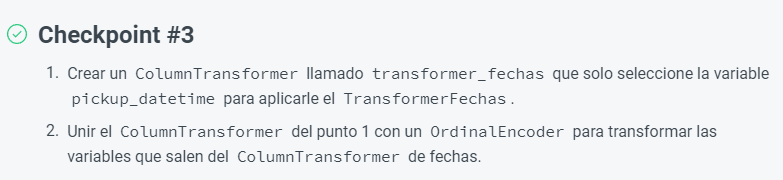

In [19]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols = ["vendor_id", "pickup_borough", "pickup_datetime"]

transformer_fechas = ColumnTransformer(
    [
        #TODO: Punto 1 de Checkpoint 3
        ("transfomer_fechas", TransformerFechas(), ["pickup_datetime"])
    ],
    remainder="passthrough"
)

cat_pipeline = Pipeline(
    [
        #TODO: Punto 2 de Checkpoint 3
        ("transformer_fechas", transformer_fechas),
        ("ordinal_encoder", OrdinalEncoder())
    ]
)

X_cat = cat_pipeline.fit_transform(train_df[cat_cols])
print(X_cat)

[[ 3. 21.  0.  1.]
 [ 6. 21.  1.  2.]
 [ 1. 18.  1.  2.]
 ...
 [ 6.  2.  0.  3.]
 [ 1. 23.  1.  1.]
 [ 1.  2.  1.  2.]]


In [20]:
display(cat_pipeline)

Pipeline(steps=[('transformer_fechas',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transfomer_fechas',
                                                  TransformerFechas(),
                                                  ['pickup_datetime'])])),
                ('ordinal_encoder', OrdinalEncoder())])

## Unión de Pipelines
Por último, usaremos nuevamente el `ColumnTransformer` para determinar cuáles son las variables numéricas y las variables catégoricas en nuestros datos. Definiendo varios elementos en la lista que le pasamos al `ColumnTransformer` le hacemos saber a `sklearn` que queremos diferentes transformaciones para las columnas y al final queremos unirlas para que todas queden en un solo `numpy` array. En nuestro caso, unimos las columnas que resultan del preprocesamiento de las categóricas y del de las numéricas.

In [21]:
from sklearn.pipeline import FeatureUnion

full_pipeline = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, num_cols),
        ("cat_pipeline", cat_pipeline, cat_cols)
    ]
)

X_transformed = full_pipeline.fit_transform(train_df, y_train)
print(X_transformed.shape)

(1085891, 6)


En este diagrama podemos ver que ejecutamos las transformaciones por separado para las variables numéricas y las categóricas y al final las unimos para tener los datos en un array que le pasaremos al modelo al momento de entrenar.

In [22]:
display(full_pipeline)

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('transformer_coord',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('transformer_dist',
                                                                                   TransformerDistancia(),
                                                                                   ['pickup_longitude',
                                                                                    'pickup_latitude',
                                                                                    'dropoff_longitude',
                                                                                    'dropoff_latitude'])])),
                                                 ('scaler', StandardScaler())]),
                                 ['passenger_count', 'pickup_longitude',
                                  'pickup_latitude', 'dropoff_longitude',
                                  'dropoff_latitude']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('transformer_fechas',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('transfomer_fechas',
                                                                                   TransformerFechas(),
                                                                                   ['pickup_datetime'])])),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 ['vendor_id', 'pickup_borough',
                                  'pickup_datetime'])])

## Guardar Pipeline a Disco

Además de tener una clara separación entre los métodos `.fit()` y `.transform()`, la ventaja de escribir todo nuestro proceso como un solo pipeline `(full_pipeline)` es que podemos guardar en disco el objeto que usamos para preprocesar. Esto es útil para tener todas las transformaciones definidas en un objeto al momento que queramos hacer reproducibles nuestras transformaciones para, por ejemplo, desplegar nuestro modelo.

Creamos un contexto usando `open()` y usamos la función `dill.dump()` para guardar nuestro flujo de preprocesamiento en disco

In [23]:
!pip install dill
import dill

dill.settings['recurse'] = True

with open("full_pipeline.pkl",  "wb") as f:
    dill.dump(full_pipeline, f)

Para cargar nuestro flujo, usamos la función `dill.load()`. Además verificamos que el resultado de las transformaciones con el flujo que teníamos en el notebook y el que cargamos desde el disco es idéntico.

In [24]:
with open("full_pipeline.pkl", "rb") as f:
    loaded_pipeline = dill.load(f)
    
X_loaded = loaded_pipeline.transform(train_df)
print((X_loaded == X_transformed).all())

True


## Transformación de Datos

In [25]:
with open("full_pipeline.pkl", "rb") as f:
    preprocessor = dill.load(f)

X_train = full_pipeline.transform(train_df)
X_val =full_pipeline.transform(val_df)

--------------------------------------------------------------------------

# scikit-learn y MLflow

# Entrenar Modelos

## Baseline con DummyRegressor

Una opción que nos ofrece `sklearn` es entrenar modelos dummy. Estos son modelos que predicen lo mismo para todos los casos (en este caso el promedio) y nos sirven como una medida de cuál es el rendimiento mínimo para un problema. Si por alguna razón nuestro modelo tiene peor desempeño que el modelo dummy, tenemos que revisar nuestro modelo porque probablemente tenemos errores en la implementación.

En este caso vamos a usar el `DummyRegressor` que siempre predice la media de los datos de entrenamiento. La función `evaluar_predicciones` es una ayuda para poder calcular varias métricas de un modelo usando metricas incluídas de `scikit-learn`.


In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, mean_squared_log_error

def evaluar_predicciones(y_pred, y_true):
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mape = mean_absolute_percentage_error(y_pred=y_pred, y_true=y_true)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape}")
    print(f"RMSE: {rmse}")

In [27]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_train_dummy = dummy_model.predict(X_train)
y_val_dummy = dummy_model.predict(X_val)

print("TRAIN")
evaluar_predicciones(y_pred=y_train_dummy, y_true=y_train)

print("VALIDATION")
evaluar_predicciones(y_pred=y_val_dummy, y_true=y_val)

TRAIN
MAE: 468.61
MAPE: 0.95585624685749
RMSE: 683.1658889831872
VALIDATION
MAE: 468.42
MAPE: 0.9567650882594899
RMSE: 680.0030431781618


### Baseline con regresión lineal
Otra buena medida es siempre empezar con un modelo lineal. Así tenemos una medida de cómo se desempeña un modelo sencillo.
Algo para notar es que sin importar el modelo, los modelos de sklearn siempre siguen el mismo proceso. 
1. Inicializar modelo con la clase de `sklearn`. 

2. Ejecutar función `.fit(X_train, y_train`. 

3. Ejecutar función `.predict(X)` para generar las predicciones.


Esta consistencia en el proceso simplifica el uso de diferentes modelos.

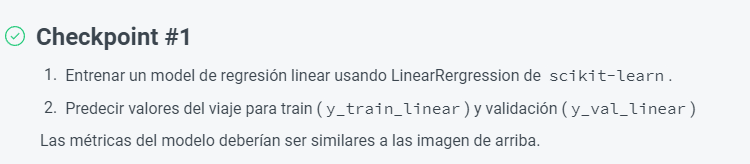

In [28]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_train_linear = linear_model.predict(X_train)
y_val_linear = linear_model.predict(X_val)

print("TRAIN")
evaluar_predicciones(y_pred=y_train_linear, y_true=y_train)

print("VALIDATION")
evaluar_predicciones(y_pred=y_val_linear, y_true=y_val)

TRAIN
MAE: 296.09
MAPE: 0.5533021393418204
RMSE: 487.05043254440756
VALIDATION
MAE: 295.55
MAPE: 0.5540681395532695
RMSE: 529.0958979710376


# ¿Cómo comparar modelos más allá de un print? MLFlow 🙌

Imprimiendo los resultados nos podemos dar cuenta del modelo con mejores resultados. Sin embargo, comparar los resultados usando `print` es difícil cuando el número de modelos empieza a crecer. Además idealmente queremos que todos los modelos queden guardados para poder retomarlos después. Para todo esto podemos usar MLflow.

[MLflow](https://www.mlflow.org/) es una librería open-source que nos ayuda a manejar todo el ciclo de modelos de machine learning. En este caso vamos a ver cómo podemos usar MLflow para guardar resultados del desempeño de modelos para determinar cuál modelo es el mejor

Vamos a correr los mismos modelos que acabamos de comparar pero esta vez vamos a usar MLflow para ver los resultados.

In [29]:
#!pip install mlflow

import mlflow
mlflow.sklearn.autolog()

`mlflow.sklearn.autolog()` automáticamente nos ayuda a guardar varias métricas y parámetros del modelo. Sin embargo, no incluye valores para datos de validación. Para guardar métricas que no se incluyen en `.autolog` vamos a usar la función `mlflow.log_metric` dentro del context manager de `run`.

Vamos primero a usar el modelo dummy y vamos a poner `run_name="dummy"` para poder verlo con el nombre correcto en MLflow.

In [30]:
with mlflow.start_run(run_name="dummy") as run:
    dummy_model.fit(X_train, y_train)
    y_pred_val = dummy_model.predict(X_val)
    val_mae = mean_absolute_error(y_pred=y_pred_val, y_true=y_val)
    val_rmse = mean_squared_error(y_pred=y_pred_val, y_true=y_val, squared=False)
    val_mape = mean_absolute_percentage_error(y_pred=y_pred_val, y_true=y_val)
    val_r2 = r2_score(y_pred=y_pred_val, y_true=y_val)

    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mape", val_mape)
    mlflow.log_metric("val_r2", val_r2)

Una vez termine de correr esta celda debemos abrir la interfaz de MLflow para ver los resultados. Deberíamos encontrar una nueva carpeta llamada `mlruns` en la ubicación donde corrió este notebook. Una vez estemos en la carpeta donde está `mlruns`, debemos ir a un terminal a esa ubicación y ejecutamos el comando}

`mlflow ui`

Ahí nos debería salir el mensaje de que está iniciando un servidor y dar la ruta para acceder. (normalmente la ruta es http://127.0.0.1:5000). Copiamos esa dirección en un navegador y ahí ya deberíamos ver la interfaz de MLflow.

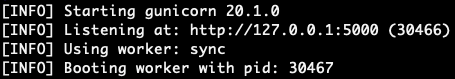

En la interfaz de MLflow estarán los modelos que corramos usando MLflow y podemos filtrar u ordenar por métricas o parámetros que consideramos importantes. En general, con la interfaz de MLflow tenemos una base de datos de modelos que podemos analizar fácilmente.

Además, si hacemos click un alguna de las runs (click en la columna Start Time) podemos ver que tenemos los datos más detallados y los artifacts de cada run. Los artifacts pueden ser todo tipo de archivos (por ejemplo imágenes y CSVs) que nos ayudan a guardar lo relevante de cada caso como el modelo o el ambiente de conda desde el que corrimos el modelo.

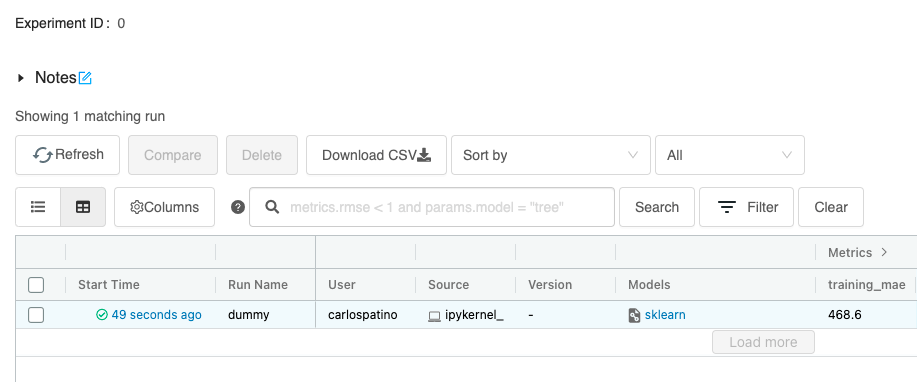

Ahora corramos nuevamente la regresión lineal para que quede registrada en MLflow. En este caso vamos a guardar nuestro preprocesador que quede asociado a cada run usando `.log_artifact`

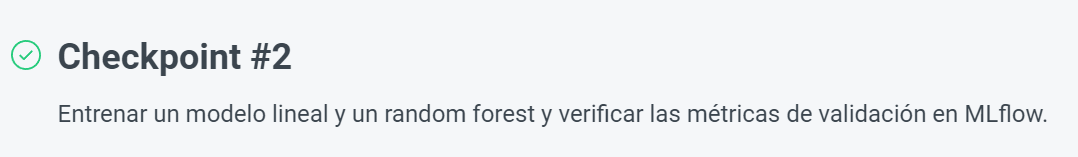

In [31]:
# Modelo Lineal 

with mlflow.start_run(run_name="linear_regression") as run:
    linear_model.fit(X_train, y_train)
    y_pred_val = linear_model.predict(X_val)
    val_mae = mean_absolute_error(y_pred=y_pred_val, y_true=y_val)
    val_rmse = mean_squared_error(y_pred=y_pred_val, y_true=y_val, squared=False)
    val_mape = mean_absolute_percentage_error(y_pred=y_pred_val, y_true=y_val)
    val_r2 = r2_score(y_pred=y_pred_val, y_true=y_val)

    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mape", val_mape)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_artifact("full_pipeline.pkl")

Ahora que tenemos la regresión lineal y el modelo dummy en MLflow, vamos a probar con un modelo más complejo como el Random Forest. Por ahora vamos a dejar los parámetros por defecto que trae la clase `RandomForestRegressor` excepto `n_jobs` que lo vamos a poner con el parámetro `n_jobs=2`. Poner n_jobs=2 hace que el modelo corra en paralelo en 2 procesadores.

In [32]:
# Random forest

from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run(run_name="random_forest") as run:
    rf_model = RandomForestRegressor(n_jobs=2)    
    rf_model.fit(X_train, y_train)
    y_pred_val = rf_model.predict(X_val)
    val_mae = mean_absolute_error(y_pred=y_pred_val, y_true=y_val)
    val_rmse = mean_squared_error(y_pred=y_pred_val, y_true=y_val, squared=False)
    val_mape = mean_absolute_percentage_error(y_pred=y_pred_val, y_true=y_val)
    val_r2 = r2_score(y_pred=y_pred_val, y_true=y_val)

    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mape", val_mape)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_artifact("full_pipeline.pkl")